In [3]:
import argparse
import os
os.umask(0)
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"
os.environ["OMP_NUM_THREADS"] = "1"
import pickle
import sys
from importlib import import_module

import torch
from torch.utils.data import DataLoader, Sampler
from torch.utils.data.distributed import DistributedSampler
from tqdm import tqdm

from data import InteDataset
from data import ArgoTestDataset
from utils import Logger, load_pretrain

# define parser
parser = argparse.ArgumentParser(description="Argoverse Motion Forecasting in Pytorch")
parser.add_argument(
    "-m", "--model", default="lanegcn", type=str, metavar="MODEL", help="model name"
)
parser.add_argument("--eval", action="store_true", default=True)
parser.add_argument(
    "--split", type=str, default="val", help='data split, "val" or "test"'
)
parser.add_argument(
    "--weight", default="/media/drl/datas/zyk/LaneGCN/results/lanegcn_interaction/36.000.ckpt", type=str, metavar="WEIGHT", help="checkpoint path"
)
# parser.add_argument(
#     "--weight", default="/media/drl/datas/zyk/LaneGCN/results/lanegcn/17.000.ckpt", type=str, metavar="WEIGHT", help="checkpoint path"
# )


_StoreAction(option_strings=['--weight'], dest='weight', nargs=None, const=None, default='/media/drl/datas/zyk/LaneGCN/results/lanegcn_interaction/36.000.ckpt', type=<class 'str'>, choices=None, help='checkpoint path', metavar='WEIGHT')

In [4]:
root_path = '/home/user/Projects/LaneGCN_modified'
sys.path.insert(0, root_path)

model = import_module("lanegcn")
config, _, collate_fn, net, loss, post_process, opt = model.get_model()


In [3]:
config

{'display_iters': 79872,
 'val_iters': 79872,
 'save_freq': 1.0,
 'epoch': 0,
 'horovod': True,
 'opt': 'adam',
 'num_epochs': 50,
 'lr': [0.001, 0.0001],
 'lr_epochs': [32],
 'lr_func': <utils.StepLR at 0x7f5d3be8edd0>,
 'save_dir': '/home/user/Projects/LaneGCN_modified/results/lanegcn',
 'batch_size': 16,
 'val_batch_size': 16,
 'workers': 0,
 'val_workers': 0,
 'train_split': '/home/user/Projects/LaneGCN_modified/dataset/train/data',
 'val_split': '/home/user/Projects/LaneGCN_modified/dataset/val/data',
 'test_split': '/home/user/Projects/LaneGCN_modified/dataset/test_obs/data',
 'preprocess': True,
 'preprocess_train': '/home/user/Projects/LaneGCN_modified/dataset/preprocess/val_crs_dist6_angle90.p',
 'preprocess_val': '/home/user/Projects/LaneGCN_modified/dataset/preprocess/val_crs_dist6_angle90.p',
 'preprocess_test': '/home/user/Projects/LaneGCN_modified/dataset/preprocess/test_test.p',
 'rot_aug': False,
 'pred_range': [-100.0, 100.0, -100.0, 100.0],
 'num_scales': 7,
 'n_actor

In [5]:
ckpt_path = "/home/user/Datasets/interpolated/preprocess_results_10s_interp10_thr10_scale7/results/30.000.ckpt"
# ckpt_path = "/media/drl/datas/zyk/LaneGCN/results/lanegcn/17.000.ckpt"

if not os.path.isabs(ckpt_path):
    ckpt_path = os.path.join(config["save_dir"], ckpt_path)
ckpt = torch.load(ckpt_path, map_location=lambda storage, loc: storage)
load_pretrain(net, ckpt["state_dict"])
net.eval()


Net(
  (actor_net): ActorNet(
    (groups): ModuleList(
      (0): Sequential(
        (0): Res1d(
          (conv1): Conv1d(3, 32, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
          (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
          (relu): ReLU(inplace=True)
          (bn1): GroupNorm(1, 32, eps=1e-05, affine=True)
          (bn2): GroupNorm(1, 32, eps=1e-05, affine=True)
          (downsample): Sequential(
            (0): Conv1d(3, 32, kernel_size=(1,), stride=(1,), bias=False)
            (1): GroupNorm(1, 32, eps=1e-05, affine=True)
          )
        )
        (1): Res1d(
          (conv1): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
          (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
          (relu): ReLU(inplace=True)
          (bn1): GroupNorm(1, 32, eps=1e-05, affine=True)
          (bn2): GroupNorm(1, 32, eps=1e-05, affine=True)
        )
      )
    

In [6]:
# dataset = InteDataset('/home/user/Datasets/interpolated/preprocess_results_10s/tmp/')
dataset = InteDataset('/home/user/Datasets/interpolated/preprocess_results_10s_interp10_thr10_scale7/tmp/')
data_loader = DataLoader(
    dataset,
    batch_size=config["val_batch_size"],
    num_workers=config["val_workers"],
    collate_fn=collate_fn,
    shuffle=True,
    pin_memory=True,
)

# begin inference
preds = {}
gts = {}
cities = {}

data_list = []
for ii, data in tqdm(enumerate(data_loader)):
    data = dict(data)
    with torch.no_grad():
        output = net(data)
        results = [x.detach().cpu().numpy() for x in output["reg"]]
        display = post_process(output, data)
#     for i, pred_traj in enumerate(results):
#         if i != 0:
#             continue
#         break
#         preds[argo_idx] = pred_traj.squeeze()
#         cities[argo_idx] = data["city"][i]
#         # cities[argo_idx] = "Test"

#         gts[argo_idx] = data["gt_preds"][i][0] if "gt_preds" in data else None

1it [00:01,  1.60s/it]


In [7]:
def traj_plot(traj, rot, orig, ax=None, c=""):

    
    if isinstance(traj, torch.Tensor):
        traj = traj.numpy()
    rot = rot.numpy()
    orig = orig.numpy()
    
    centerline = np.array([traj[:, 0] - orig[0], traj[:, 1] - orig[1]]).T
#     print(centerline)
    centerline = np.matmul(rot, (centerline.reshape(-1, 2)).T).T

    if ax is not None:
        ax.plot(centerline[:, 0], centerline[:, 1], c)
        
    return centerline


In [8]:
output['cls'][idx]

NameError: name 'idx' is not defined

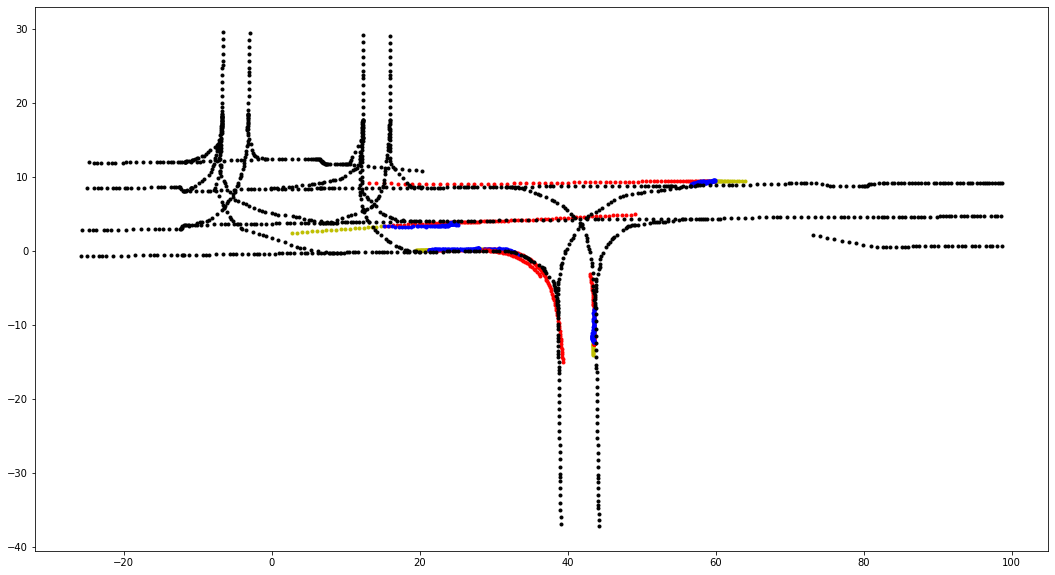

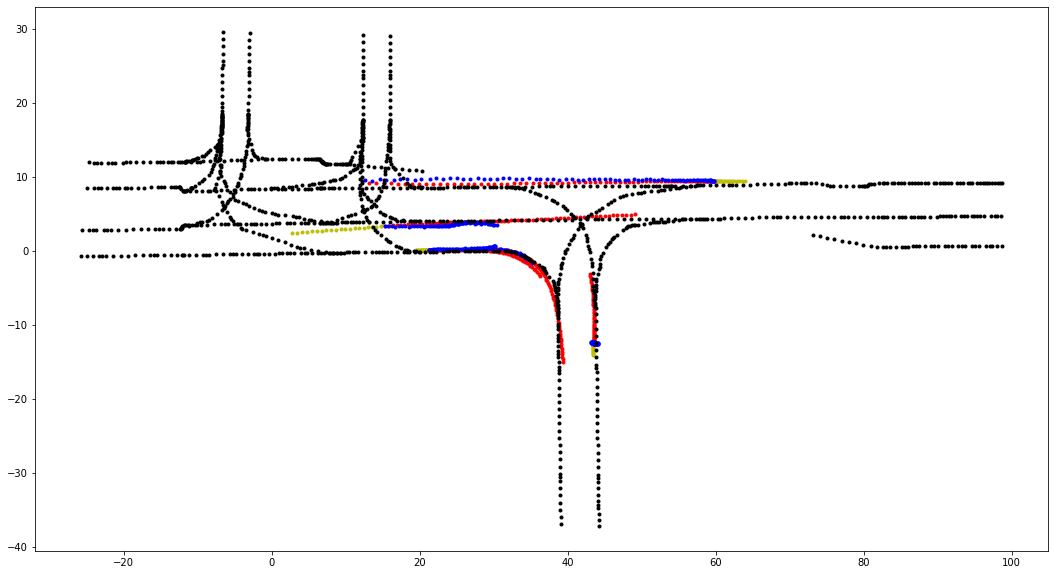

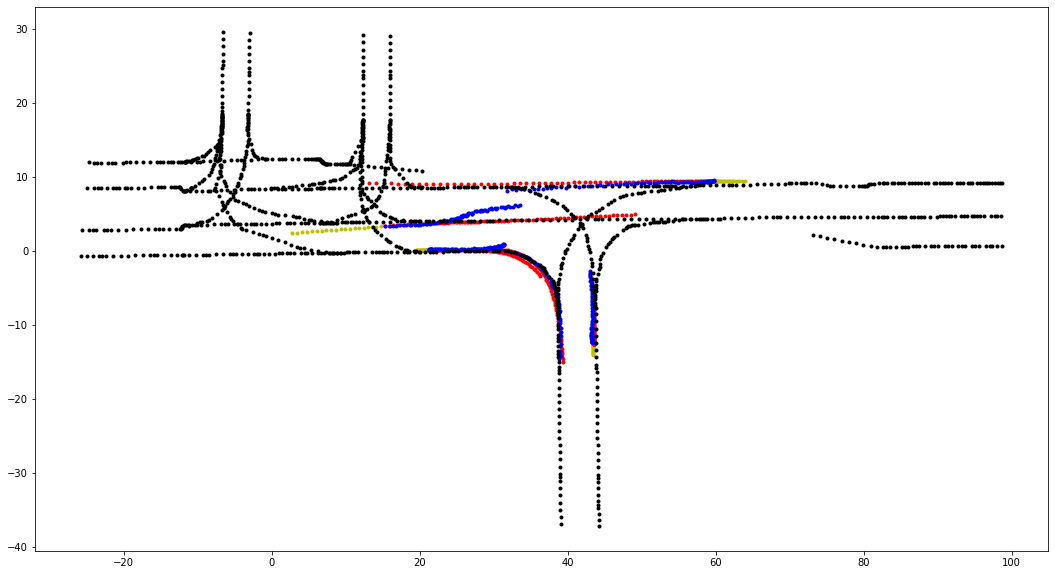

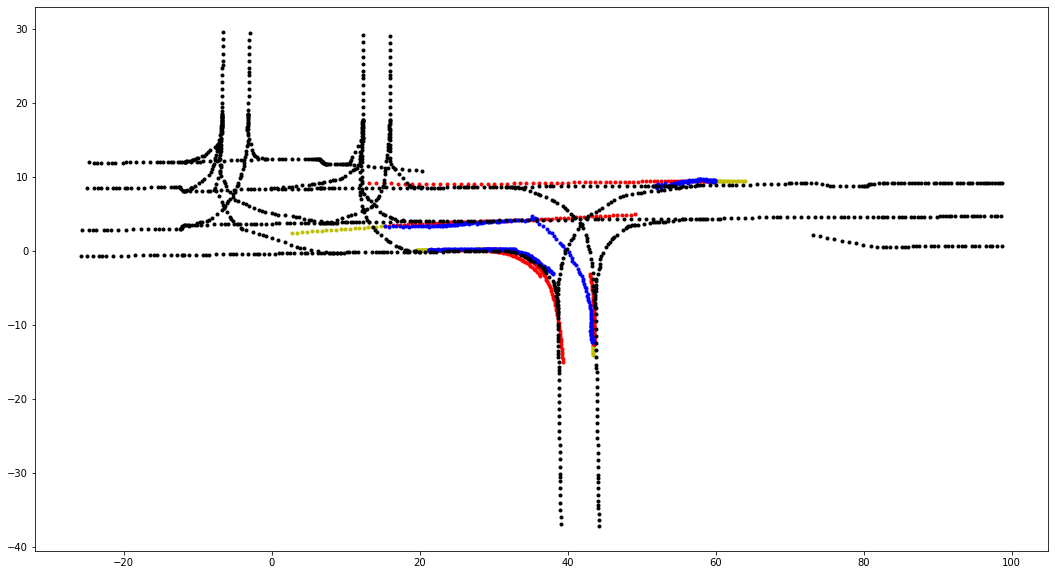

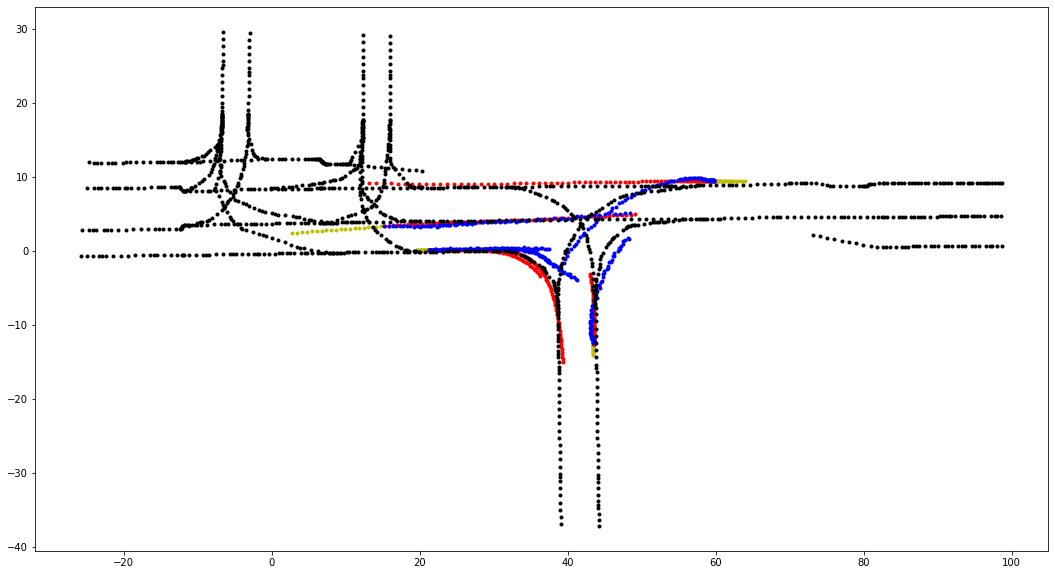

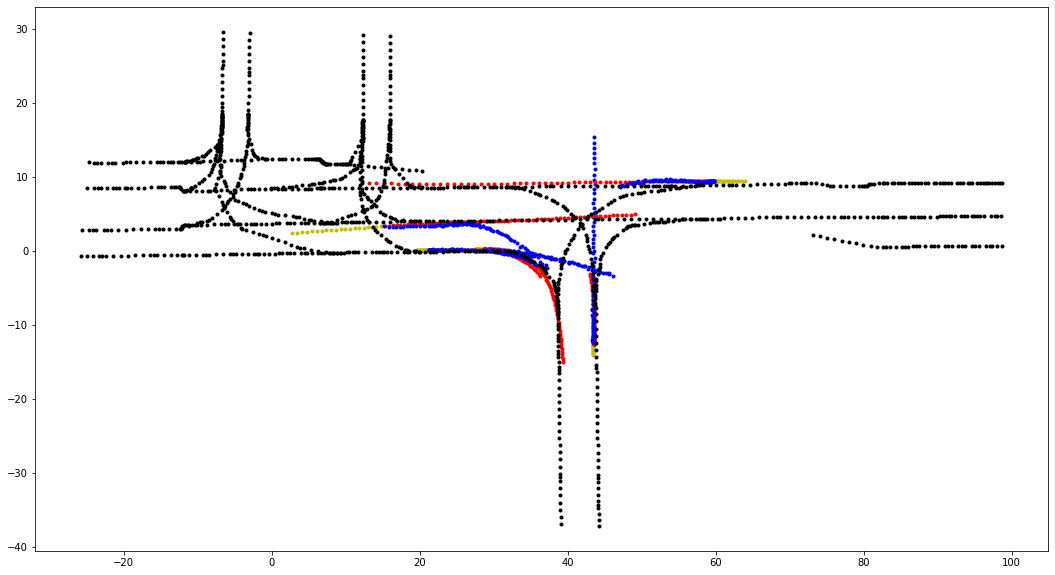

In [12]:
import numpy as np
import matplotlib.pyplot as plt
idx = 6


orig = data['orig'][idx]
rot = data['rot'][idx]
graph = data['graph'][idx]
    



gt_preds = data['gt_preds'][idx]
has_preds = data['has_preds'][idx]
for k in range(6):
    fig, ax = plt.subplots(1,1, figsize=(20,10))
    ax.set_aspect('equal', adjustable='box')
#     plt.gca().invert_xaxis()
#     plt.gca().invert_yaxis()     
    for a in range(data['gt_preds'][idx].shape[0]):
        mask = has_preds[a]
        gt_pred = gt_preds[a][mask]
        
        hist = data['feats'][idx][a]
        plt.plot(hist[:, 0], hist[:, 1], 'y.')
        traj_plot(gt_pred,  rot, orig, ax, 'r.')

        pred_traj = results[idx][a, k, :, :]
        traj_plot(pred_traj, rot, orig, ax, 'b.')


    ctrs = graph['ctrs']
    ax.plot(ctrs[:, 0], ctrs[:, 1], 'k.')

#     plt.savefig('/home/user/Projects/LaneGCN_modified/results/remote_results/0603_5s/' + str(idx) + '_' + str(k))
#     plt.savefig('/home/user/Logs/0610/interp+filter10_res30/' + str(idx) + '_' + str(k))
    plt.show()


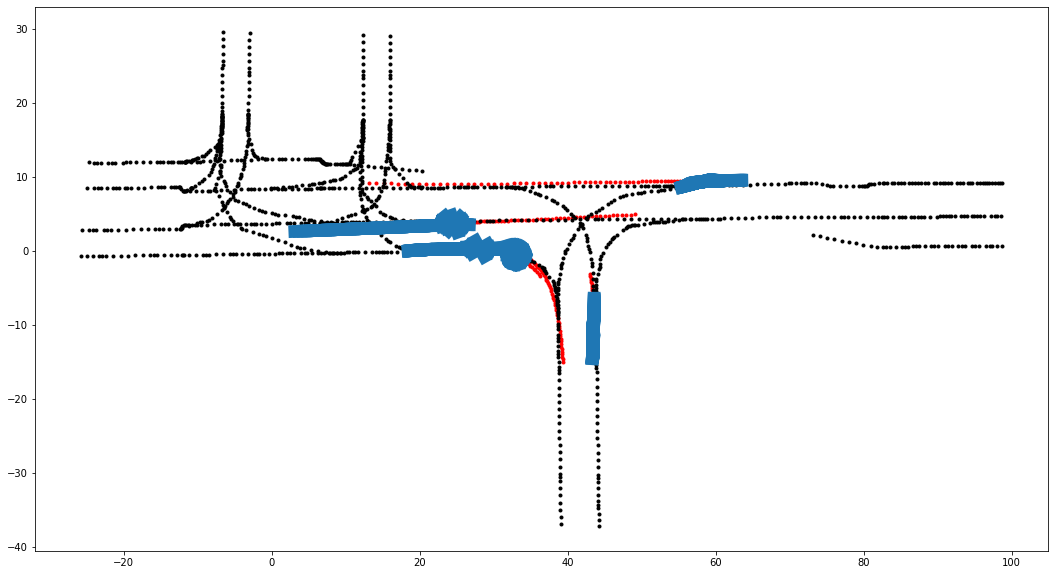

In [13]:
k = 0

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.axes
from matplotlib.patches import Polygon,Circle
from matplotlib.collections import PatchCollection


def rect_plot(pos, rot, orig, w, l, ax, c):
    rot = rot.numpy()
    orig = orig.numpy()    

    ax.plot(centerline[:, 0], centerline[:, 1], c)
    return centerline

def polygon_xy_from_motionstate(ms, width, length):
    lowleft = (ms[0] - length / 2., ms[1] - width / 2.)
    lowright = (ms[0] + length / 2., ms[1] - width / 2.)
    upright = (ms[0] + length / 2., ms[1] + width / 2.)
    upleft = (ms[0] - length / 2., ms[1] + width / 2.)
    return rotate_around_center(np.array([lowleft, lowright, upright, upleft]), np.array([ms[0], ms[1]]), yaw=ms[2])

def rotate_around_center(pts, center, yaw):
    return np.dot(pts - center, np.array([[np.cos(yaw), np.sin(yaw)], [-np.sin(yaw), np.cos(yaw)]])) + center


import csv

csv_file = '/home/user/Projects/interaction_gyt/recorded_trackfiles/DR_USA_Intersection_EP0/vehicle_tracks_000.csv'
widths = {}
lengths = {}
with open(csv_file, 'r') as f:
    reader = csv.reader(f)
    for row in reader:
        track_id = row[0]
        if track_id not in widths:
            widths[track_id] = row[10]
            lengths[track_id] = row[9]


            
import numpy as np
import matplotlib.pyplot as plt
# idx = 3


orig = data['orig'][idx]
rot = data['rot'][idx]
graph = data['graph'][idx]
gt_preds = data['gt_preds'][idx]
has_preds = data['has_preds'][idx]

fig, ax = plt.subplots(1,1, figsize=(20,10))
ax.set_aspect('equal', adjustable='box')

width = 1.72
length = 4.15

entire_trajs = np.zeros([gt_preds.shape[0], 100, 3])
for a in range(gt_preds.shape[0]):
    mask = has_preds[a]
    gt_pred = gt_preds[a][mask]

    hist = data['feats'][idx][a][:,:2]
    pred_traj = traj_plot(results[idx][a, k, :, :], rot, orig)
    plt.plot(hist[:, 0], hist[:, 1], 'y.')
    traj_plot(gt_pred,  rot, orig, ax, 'r.')
    
    entire_traj = np.concatenate([hist.numpy(), pred_traj], 0)   
    Xseq = entire_traj[:, 0]
    Yseq = entire_traj[:, 1]

    sp = spline5(Xseq, Yseq)
#     spx = spline5(Xseq)
#     spy = spline5(Yseq)

    T = len(Xseq)
    for time_stamp in range(T):
#         x, dx = spx.cal(time_stamp / (T - 1))
#         y, dy = spy.cal(time_stamp / (T - 1))    
        x, y, dx, dy = sp.cal(time_stamp / (T - 1))
        entire_trajs[a, time_stamp, 0] = x
        entire_trajs[a, time_stamp, 1] = y
        entire_trajs[a, time_stamp, 2] = math.atan2(dy, dx)

    
for time_stamp in range(20 + 80):
    for a in range(gt_preds.shape[0]):
        ms = entire_trajs[a][time_stamp]
        rect = matplotlib.patches.Polygon(polygon_xy_from_motionstate(ms, width, length), closed=True, zorder=20)
        ax.add_patch(rect)


# ax.plot(entire_traj[:, 0], entire_traj[:, 1], 'b.')
    
ctrs = graph['ctrs']
ax.plot(ctrs[:, 0], ctrs[:, 1], 'k.')

#     plt.savefig('/home/user/Projects/LaneGCN_modified/results/remote_results/0603_5s/' + str(idx) + '_' + str(k))
#     plt.savefig('/home/user/Videos/0603/8s/' + str(idx) + '_' + str(k))
plt.show()

In [14]:
%%time
import matplotlib.animation as animation
from IPython.display import HTML
import matplotlib.colors as colors

def create_animation():
  """ Creates a Matplotlib animation of the given images."""

  plt.ioff()
  fig, ax = plt.subplots(1,1, figsize=(20, 20))

#   plt.gca().invert_xaxis()
#   plt.gca().invert_yaxis() 
    

  ax.set_aspect('equal', adjustable='box')
    
  plt.ion()
  ctrs = graph['ctrs']
  ax.plot(ctrs[:, 0], ctrs[:, 1], 'k.')

  for a in range(data['gt_preds'][idx].shape[0]):
    hist = data['feats'][idx][a][:,:2]
    plt.plot(hist[:, 0], hist[:, 1], 'y.')
    traj_plot(gt_preds[a],  rot, orig, ax, 'r.')

  def animate_func(time_stamp):
    ax.patches = []
    
    for a in range(data['gt_preds'][idx].shape[0]):
        ms = entire_trajs[a][time_stamp]
        rect = matplotlib.patches.Polygon(polygon_xy_from_motionstate(ms, width, length), closed=True, zorder=20)
        ax.add_patch(rect)


  anim = animation.FuncAnimation(
      fig, animate_func, frames=100, interval=100)
  plt.close(fig)
  return anim

anim = create_animation()
HTML(anim.to_html5_video())

CPU times: user 5.62 s, sys: 348 ms, total: 5.97 s
Wall time: 6.91 s


In [ ]:
torch.softmax(output['cls'][0], -1)

In [ ]:
output['cls']

In [ ]:
torch.arange(prediction.shape[0])
prediction.get_device()

In [ ]:
from metrics import compute_joint_metrics
compute_joint_metrics(prediction, truth, [])

In [ ]:
import csv
from tqdm import tqdm

csv_prefix = '/home/user/Downloads/collected_id_pair'
csv_folders = os.listdir(csv_prefix)

larger_than_5s = 0
files_5s = []

larger_than_8s = 0
files_8s = []

larger_than_10s = 0
files_10s = []

total_count = 0

for folder in tqdm(csv_folders):
    csv_path = os.path.join(csv_prefix, folder)
    for name in os.listdir(csv_path):
        csv_file = os.path.join(csv_path, name)
#         print(csv_file)

        with open(csv_file, 'r') as f:
            reader = csv.reader(f)
            for i in reader:
                total_count += 1
#                 print(i[3], i[4], i[5])
                if int(i[5]) - int(i[4]) > 5000:
                    larger_than_5s += 1
                    files_5s.append([i[3:]])
                    
                if int(i[5]) - int(i[4]) > 8000:
                    larger_than_8s += 1
                    files_8s.append([i[3:]])
                    
                if int(i[5]) - int(i[4]) > 10000:
                    larger_than_10s += 1
                    files_10s.append([i[3:]])


In [ ]:
print('5s ', larger_than_5s)
print('8s ', larger_than_8s)
print('10s', larger_than_10s)
total_count

In [ ]:
print(entire_trajs[a].shape)
Xseq = entire_trajs[a][:, 0]
Yseq = entire_trajs[a][:, 1]

# print(Xseq)
# print(Yseq)
# spx = spline5(Xseq)
# spy = spline5(Yseq)

# spx.cal(1)
# spy.cal(1)

# spx.plot_scatter()
# spy.plot_scatter()

sp = spline5(Xseq, Yseq)
print(sp.cal(0.0))
print(sp.cal(1.0))
sp.plot_scatter()

In [1]:
# from cvxopt  import solvers, matrix
import numpy as np
from qpsolvers import solve_qp
from numpy import array, dot
import sympy as sym
import math 

class spline5:
    def __init__(self, Xseq, Yseq):
        self.Xseq = Xseq
        self.Yseq = Yseq
        
        self.T = len(Xseq)
        order = 6
        self.order = order
        
        p = np.zeros([self.T * 2, (order + 1) * 2])
        q = np.zeros([self.T * 2, 1])
        for i in range(self.T):
            t = i / (self.T - 1)
            for j in range(order + 1):
                ttt = np.power(t, j)
                p[i][j] = ttt
                p[i + self.T][j + order + 1] = ttt
            q[i] = Xseq[i]
            q[i + self.T] = Yseq[i]
            
#         np.set_printoptions(precision=2)
#         print('p', p)
        P = np.dot(p.T, p) + np.eye((order + 1) * 2) * 0.02
        
        Q = -np.dot(q.T, p)
        Q = Q.reshape(((order + 1) * 2,))
        
        A = np.zeros([4, (order + 1) * 2])
        A[0][0] = 1
        A[1][order + 1] = 1
        A[2][:order+1] = 1
        A[3][order+1:] = 1
        
        B = np.zeros([4, 1])
        B[0] = Xseq[0]
        B[1] = Yseq[0]
        B[2] = Xseq[-1]
        B[3] = Yseq[-1]
        B = B.reshape((4,))
                
        self.sol = solve_qp(P=P, q=Q)
#         self.sol = solve_qp(P=P, q=Q, A=A, b=B)



    def cal(self, t):
        x = 0
        y = 0
        order = self.order
        dx = 0
        dy = 0
        
        if t >= 0 and t <= 1:
            for i in range(order + 1):
                ttt = np.power(t, i)
                x += self.sol[i] * ttt
                y += self.sol[i + order + 1] * ttt

            for i in range(1, order + 1):    
                ttt = np.power(t, i - 1)
                dx += self.sol[i] * i * ttt
                dy += self.sol[i + order + 1] * i * ttt
        
        return x, y, dx, dy

    def plot_scatter(self):
        X, Y = [], []

        T = [i / (self.T - 1) for i in range(self.T)]
        for t in T:
            x, y, dx, dy = self.cal(t)
            X.append(x)
            Y.append(y)

            
        plt.scatter(T, X)
        plt.scatter(T, self.Xseq, color='red')
        plt.show()        
    
        plt.scatter(T, Y)
        plt.scatter(T, self.Yseq, color='red')
        plt.show()

        plt.scatter(X, Y)
        plt.scatter(self.Xseq, self.Yseq, color='red')
        plt.show()

